# LSTM  модель с механизмом внимания для генерации музыкальных последовательностей

In [1]:
from music21 import *
import glob

In [2]:
import music21

Загружаем все музыкальные файлы

In [4]:
midif = []
for file in glob.glob("cello/*.mid"):
    print(file)
    try:
        midi = converter.parse(file).chordify()
        midif.append(midi)
    except KeyError:
        problem_files.append(file)

Создаем списки нот и длительностей по всем произведениям,возьмем длительность последовательностей в 32 ноты. 

In [5]:
seq_len = 32
notes = []
durations = []
data = []

for midi in midif:
    notes = []
    durations = []
    notes_to_parse = midi.flat.notes
    ## для каждого трека добавляем индикатор старта
    notes.extend(['<START>']*seq_len)
    durations.extend(['<START>']*seq_len)
    ##добавляем в списки ноты и длительности
    for element in notes_to_parse:
        if isinstance(element, note.Note): ##если это нота то добавляем высоту в строковом формате
            if element.isRest:
                notes.append(str(element.name))
                durations.append(element.duration.quarterLength)
            else:
                notes.append(str(element.nameWithOctave))
            
                durations.append(element.duration.quarterLength)
        elif isinstance(element, chord.Chord):##если это аккорд, то добавляем информацию как из аккорда
            notes.append('.'.join(str(n) for n in element.pitches))
            durations.append(element.duration.quarterLength)
    ##общий массив данных
    data.append([notes,durations])

In [6]:
midis = data

In [7]:
seq_len = 32
all_notes = set()
all_durs = set()
for elem in midis:
    all_notes.update(elem[0])
    all_durs.update(elem[1])

Сохраняем

In [63]:
import pickle
with open("cello_model/all_notes", "wb") as fp:   
    pickle.dump(all_notes, fp)
with open("cello_model/all_durs", "wb") as fp:   
    pickle.dump(all_durs, fp)
with open("cello_model/midis", "wb") as fp:   
    pickle.dump(midis, fp)

Загружаем

In [8]:
import pickle
with open("cello_model/all_notes", "rb") as fp:   
    all_notes = pickle.load(fp)
with open("cello_model/all_durs", "rb") as fp:   
    all_durs = pickle.load(fp)
with open("cello_model/midis", "rb") as fp:   
    midis = pickle.load(fp)

Множества всех нот и длительностей

In [9]:
all_notes

{'<START>',
 'A2',
 'A2.A3',
 'A2.B-3',
 'A2.B2',
 'A2.C3',
 'A2.D3',
 'A2.E-3',
 'A2.E3',
 'A2.E3.A3',
 'A2.E3.C#4',
 'A2.E3.C#4.A4',
 'A2.E3.C#4.E4',
 'A2.E3.C#4.G#4',
 'A2.E3.C4',
 'A2.E3.D4',
 'A2.F#3',
 'A2.F#3.C4',
 'A2.F#3.D4',
 'A2.F#3.D4.A4',
 'A2.F#3.D4.E4',
 'A2.F#3.D4.F#4',
 'A2.F#4',
 'A2.F3',
 'A2.F3.C4',
 'A2.F3.D4',
 'A2.F3.D4.A4',
 'A2.G3',
 'A2.G3.C#4',
 'A2.G3.D4',
 'A3',
 'A3.B-3',
 'A3.B3',
 'A3.B3.C#4',
 'A3.B3.C#4.D4',
 'A3.B3.C4',
 'A3.C#4',
 'A3.C#4.E4',
 'A3.C4',
 'A3.D4',
 'A3.E4',
 'A3.E4.F#4',
 'A3.E4.G4',
 'A3.F#4',
 'A3.F#4.G4',
 'A3.F4',
 'A3.G4',
 'A4',
 'A4.B4',
 'B-2',
 'B-2.A3',
 'B-2.B-3',
 'B-2.C3',
 'B-2.D3',
 'B-2.D3.A3',
 'B-2.D3.E-3.G#3',
 'B-2.D3.G#3',
 'B-2.E-3',
 'B-2.E3',
 'B-2.E3.D4',
 'B-2.F#3.C#4.E4',
 'B-2.F3',
 'B-2.F3.C4',
 'B-2.F3.D4',
 'B-2.F3.E-4',
 'B-2.G#3',
 'B-2.G3',
 'B-2.G3.D4',
 'B-3',
 'B-3.B3.E4',
 'B-3.C4',
 'B-4',
 'B-4.B4.C#5.D5',
 'B2',
 'B2.A3',
 'B2.C#3',
 'B2.C3',
 'B2.C3.D3',
 'B2.D3',
 'B2.D3.B3.F#4',
 'B2.E-3',
 

In [10]:
all_durs

{0.25,
 0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 Fraction(1, 12),
 Fraction(1, 3),
 Fraction(1, 6),
 2.0,
 2.5,
 Fraction(2, 3),
 3.0,
 4.0,
 Fraction(4, 3),
 '<START>'}

In [11]:
len(all_notes)

470

In [12]:
len(all_durs)

17

Мэппинг нотам и длительностям целых чисел

In [13]:
note_to_int = dict((lnote, number) for number, lnote in enumerate(all_notes))

In [14]:
dur_to_int = dict((dur, number) for number, dur in enumerate(all_durs))

Создание датасета

In [15]:
import numpy as np

Для каждой последовательности ожидаемое сгенерированное значение - следующая нота и ее длительность

In [16]:
X_note = []
X_dur = []
Y_note = []
Y_dur = []
for nd in midis:
    for i in range(0,len(nd[0])-seq_len):
        for lnote,dur in zip(nd[0][i:i+seq_len],nd[1][i:i+seq_len]):
            X_note.append(note_to_int[lnote])
            X_dur.append(dur_to_int[dur])
        Y_note.append(note_to_int[nd[0][i+seq_len]])
        Y_dur.append(dur_to_int[nd[1][i+seq_len]])

In [17]:
#обучающие данные для нот
X_note = np.array(X_note).astype('float32').reshape((-1, seq_len,1))
X_note.shape

(27418, 32, 1)

In [18]:
#обучающие данные для длительностей
X_dur = np.array(X_dur).astype('float32').reshape((-1, seq_len,1))
X_dur.shape

(27418, 32, 1)

In [19]:
#лейблы нот
Y_note = np.array(Y_note).astype('float32').reshape(-1,1)
Y_note.shape

(27418, 1)

In [20]:
#лейблы длительностей
Y_dur = np.array(Y_dur).astype('float32').reshape(-1,1)
Y_dur.shape

(27418, 1)

Архитектура модели

In [21]:
from keras.layers import (Input, Embedding, Concatenate, LSTM, Dense, Reshape, 
                          Activation, Permute, Multiply, Lambda, Dropout, RepeatVector)
from keras.models import Model
from keras.optimizers import RMSprop,Adam
import keras.backend as K

In [22]:
notes_in = Input(shape = (None,))
durations_in = Input(shape = (None,))
x1 = Embedding(len(all_notes), 100)(notes_in)
x2 = Embedding(len(all_durs), 100)(durations_in)
x = Concatenate()([x1,x2]) 
x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.3)(x)
x = LSTM(256, return_sequences=True)(x)
x = Dropout(0.3)(x)
##механизм внимания
e = Dense(1, activation='tanh')(x)
e = Reshape([-1])(e)
alpha = Activation('softmax')(e)
c = Permute([2, 1])(RepeatVector(256)(alpha))
c = Multiply()([x, c])
c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(256,))(c)
#выходной слой
notes_out = Dense(len(all_notes), activation = 'softmax', name = 'pitch')(c)
durations_out = Dense(len(all_durs), activation = 'softmax', name = 'duration')(c)
model = Model([notes_in, durations_in], [notes_out, durations_out])
#модель только для рассмотрения работы механизма внимания
att_model = Model([notes_in, durations_in], alpha)
opti = Adam(learning_rate = 0.001)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
optimizer=opti)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    47000       ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    1700        ['input_2[0][0]']                
                                                                                              

In [34]:
from keras.callbacks import ModelCheckpoint

In [35]:
filepath = "big_lstm_cello.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=2,        
    save_best_only=True,        
    mode='min'
)

In [36]:
from keras.utils import to_categorical

Преобразовываем выходные значения к категориальным

In [37]:
Y_note_cat = to_categorical(Y_note, len(all_notes))
Y_dur_cat = to_categorical(Y_dur, len(all_durs))

Процесс обучения

In [38]:
callbacks_list = [checkpoint]     
history = model.fit([X_note, X_dur],[Y_note_cat, Y_dur_cat],epochs = 200, batch_size=64,
          validation_split = 0.1,shuffle = True, callbacks=callbacks_list)

Epoch 1/200
386/386 [==============================] - ETA: 0s - loss: 7.0358 - pitch_loss: 5.8451 - duration_loss: 1.1907
Epoch 1: loss improved from inf to 7.03582, saving model to big_lstm_cello.hdf5
386/386 [==============================] - 15s 29ms/step - loss: 7.0358 - pitch_loss: 5.8451 - duration_loss: 1.1907 - val_loss: 7.2668 - val_pitch_loss: 6.2084 - val_duration_loss: 1.0584
Epoch 2/200
384/386 [============================>.] - ETA: 0s - loss: 4.3116 - pitch_loss: 3.6274 - duration_loss: 0.6842
Epoch 2: loss improved from 7.03582 to 4.31252, saving model to big_lstm_cello.hdf5
386/386 [==============================] - 10s 26ms/step - loss: 4.3125 - pitch_loss: 3.6275 - duration_loss: 0.6850 - val_loss: 6.8756 - val_pitch_loss: 5.9144 - val_duration_loss: 0.9612
Epoch 3/200
386/386 [==============================] - ETA: 0s - loss: 4.0737 - pitch_loss: 3.4516 - duration_loss: 0.6221
Epoch 3: loss improved from 4.31252 to 4.07373, saving model to big_lstm_cello.hdf5
386/3

In [67]:
print(history.history.keys())

dict_keys(['loss', 'pitch_loss', 'duration_loss', 'val_loss', 'val_pitch_loss', 'val_duration_loss'])


In [68]:
with open('history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [69]:
import matplotlib.pyplot as plt

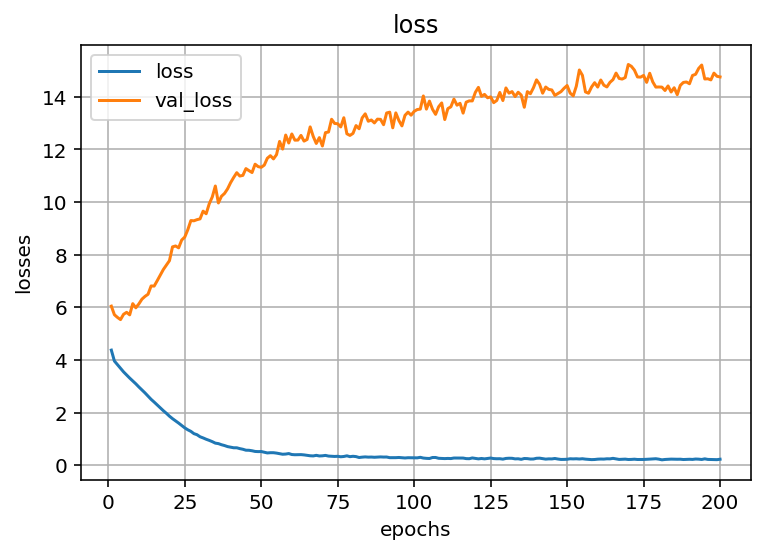

In [70]:
epochs = np.arange(1,201)
plt.plot(epochs, history.history['loss'])
epochs = np.arange(1,201)
plt.plot(epochs, history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.grid()

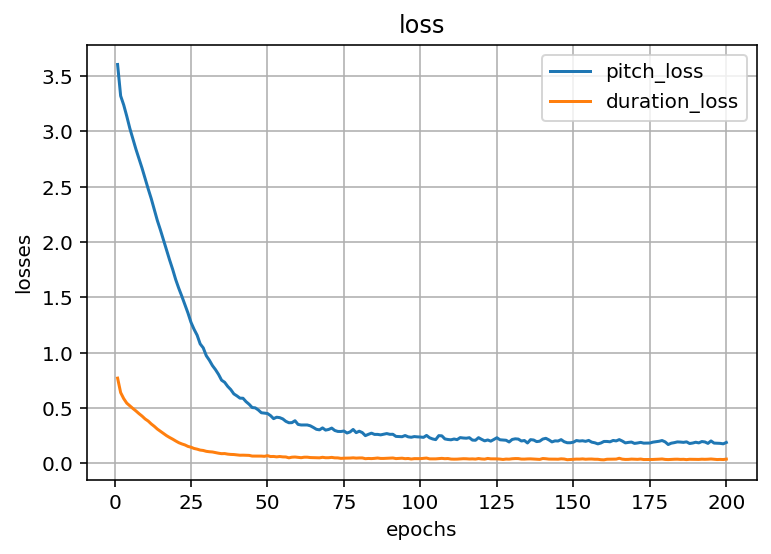

In [71]:
plt.plot(epochs, history.history['pitch_loss'])
plt.plot(epochs, history.history['duration_loss'])
plt.legend(['pitch_loss','duration_loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.grid()

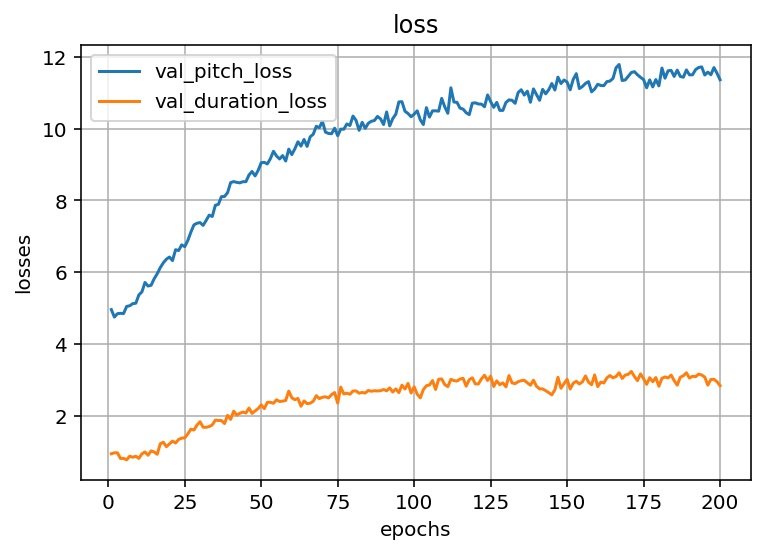

In [98]:
plt.plot(epochs, history.history['val_pitch_loss'])
plt.plot(epochs, history.history['val_duration_loss'])
plt.legend(['val_pitch_loss','val_duration_loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.grid()

In [39]:
model.save_weights('big_lstm_cello.hdf5')

In [24]:
model.load_weights('big_lstm_cello.hdf5')

Словари для декодирования целых чисел в ноты и длительности

In [40]:
int_to_note = {y: x for x, y in note_to_int.items()}
int_to_dur = {y: x for x, y in dur_to_int.items()}

Функция предсказания с температурой(для решения проблемы детерминированных предсказаний)

In [41]:
def pred_with_temp(pred,temperature):
    if temperature == 0:
        return np.argmax(pred)
    else:
        pred = np.log(pred) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        return np.random.choice(len(pred), p=pred)

Функция для генерации примеров

In [42]:
def generate_sample(seq_len,temp_score=0.3):
    fnote = note_to_int['<START>']
    fdur = dur_to_int['<START>']

    temperature = 0.7

    #создаем входные последовательности из токенов старта
    note_seq = [fnote]*seq_len
    dur_seq = [fdur]*seq_len
    note_seq = np.array(note_seq).reshape(1,-1)
    dur_seq = np.array(dur_seq).reshape(1,-1)
    
    new_note = 0
    new_dur = 0
    i = 32
    pred_seq_note = note_seq
    pred_seq_dur = dur_seq
    #процесс создания последовательностей предсказаний модели (длиной 500)
    while note_seq.shape[1]!= 100+seq_len and new_note!=note_to_int['<START>'] and new_dur!=dur_to_int['<START>']:
        
        new_note, new_dur =  model.predict([pred_seq_note, pred_seq_dur],verbose=0)
        new_note = pred_with_temp(new_note[0],temperature)
        new_dur = pred_with_temp(new_dur[0],temperature)
        i+=1
        note_seq = np.append(note_seq,[[new_note]], axis= 1)
        dur_seq = np.append(dur_seq,[[new_dur]], axis= 1)
        note_seq = np.array(note_seq).reshape(1,-1)
        dur_seq = np.array(dur_seq).reshape(1,-1)
        pred_seq_note = note_seq[:,i-32:i]
        pred_seq_dur = dur_seq[:,i-32:i]
    note_text_seq = []
    dur_text_seq = []
    #декодируем
    for i in range(0,len(note_seq[0])):
        note_text_seq.append(int_to_note[note_seq[0][i]])
        dur_text_seq.append(int_to_dur[dur_seq[0][i]])

    return note_text_seq, dur_text_seq

Функция для создания самих midi-файлов

In [43]:

def create_midi(note_text_seq, dur_text_seq):
    midi_stream = stream.Stream()
    for note_pattern, duration_pattern in zip(note_text_seq, dur_text_seq):
        # Аккорд
        if ('.' in note_pattern):
            notes_in_chord = note_pattern.split('.')
            chord_notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(current_note)
                new_note.duration = duration.Duration(duration_pattern)
                new_note.storedInstrument = instrument.Violoncello()
                chord_notes.append(new_note)
            new_chord = chord.Chord(chord_notes)
            midi_stream.append(new_chord)
        elif note_pattern == 'rest':
        # пауза
            new_note = note.Rest()
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            midi_stream.append(new_note)
        elif note_pattern != '<START>':
        # нота
            new_note = note.Note(note_pattern)
            new_note.duration = duration.Duration(duration_pattern)
            new_note.storedInstrument = instrument.Violoncello()
            midi_stream.append(new_note)
    return midi_stream

Генерируем выходные семплы

In [44]:
for i in range(10):
    n,d = generate_sample(seq_len)
    midi_result = create_midi(n,d)
    midi_result.write('midi',fp = f'cello_out{i}.mid')

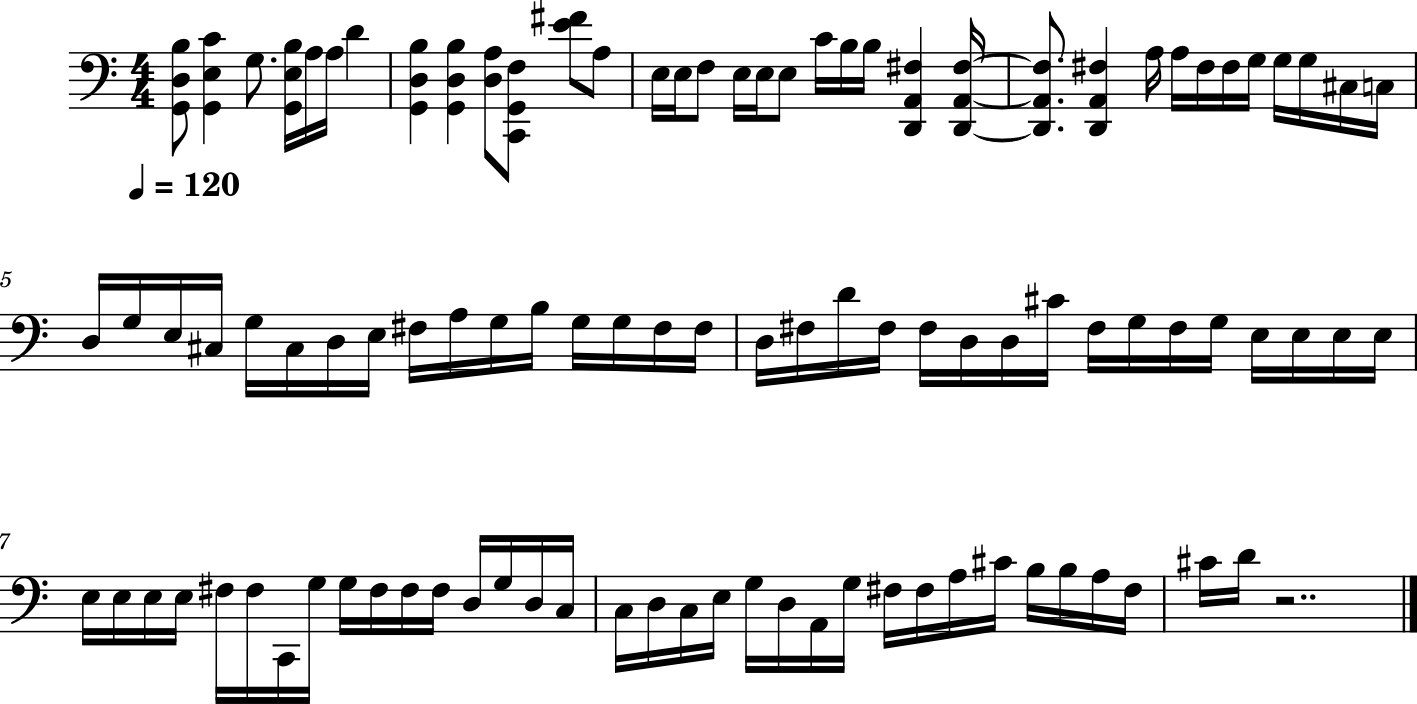

In [85]:
a = converter.parse(f'cello_out{1}.mid')
a.show()